In [ ]:
# Run once, restart kernel and proceed with the next cell
# %pip install --upgrade ipywidgets

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import training
from training import load_config, generate_basic_dataloader, generate_sppf_dataloader, get_model, train_loop, cal_regression_metrics, cal_classification_metrics
from utils.preprocessing import load_image, apply_img_preprocessing

from inference import load_saved_model, pred_degradation_value

In [3]:
torch.cuda.empty_cache()

# Training

In [4]:
config_path = "./configs/cnn.yaml"
config = load_config(config_path)
pprint(config,)

{'dataset_loc': {'train': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51_degradation_values.csv',
                           'img_dir': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51'},
                 'val': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c_degradation_values.csv',
                         'img_dir': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c'}},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_dim': 3},
 'results_loc': 'experiment_results/',
 'training': {'batch_size': 1,
              'learning_rate': 0.05,
              'num_epochs': 2,
              'num_workers': 2,
              'resume_checkpoint': None,
              'save_checkpoint_freq': 1}}


In [5]:
# # copy paste config here to edit and experiment
config = {'dataset_loc': {
                'train': {
                      'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments_v3/degradation_segment_labels_train.csv',
                      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments_v3/train/'},
                 'val': {
                     'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments_v3/degradation_segment_labels_val.csv',
                     'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments_v3/val/'}
                },
         'enable_cuda': True,
         'model': {'in_channels': 3, 'out_dim': 3},
         'results_loc': 'experiment_results/',
         'training': {'batch_size': 1,
                      'learning_rate': 0.000001,
                      'num_epochs': 10,
                      'num_workers': 2,
                      'resume_checkpoint': 'experiment_results/checkpoints/cnn_sppf_final_2025-04-07_11-11-38.pth',
                      'save_checkpoint_freq': 1}
         }

In [6]:
# # copy paste config here to edit and experiment
# config = {'dataset_loc': {
#                 'train': {
#                       'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_train_vtest.csv',
#                       'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments/train/'},
#                  'val': {
#                      'degradation_values_csv': '/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_val_vtest.csv',
#                      'img_dir': '/cs6945share/retro_project/classification_bdd100k/segments/train/'}
#                 },
#          'enable_cuda': True,
#          'model': {'in_channels': 3, 'out_dim': 3},
#          'results_loc': 'experiment_results/',
#          'training': {'batch_size': 1,
#                       'learning_rate': 0.0001,
#                       'num_epochs': 20,
#                       'num_workers': 2,
#                       'resume_checkpoint': None,
#                       'save_checkpoint_freq': 10}
#          }

In [7]:
# get required config parameters
model_config = config["model"]
train_config = config["training"]
dataset_config = config["dataset_loc"]

In [8]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [9]:
# update preprocessing config if required
# resize_height, resize_width = preprocess_config["resize_height"], preprocess_config["resize_height"]

# # in case one wants to try out different transformations
# img_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((resize_height, resize_width)),   # ensure resize same is used for mask by setting preprocess_config
#     transforms.ToTensor()
# ])

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomRotation(30),            # Rotate images randomly by up to 30 degrees
    transforms.ToTensor()                    # Convert the image to a tensor
])


# generate train data loader
train_loader, train_size = generate_sppf_dataloader(image_dir=dataset_config["train"]["img_dir"],
                                               degradation_values_csv=dataset_config["train"]["degradation_values_csv"],
                                               batch_size=train_config["batch_size"],
                                               num_workers=train_config["num_workers"], transform=train_transform   # send new transform here if required
                                        )

# generate validation data loader
val_loader, val_size = generate_sppf_dataloader(image_dir=dataset_config["val"]["img_dir"],
                                                degradation_values_csv=dataset_config["val"]["degradation_values_csv"],
                                                batch_size=train_config["batch_size"],
                                                num_workers=train_config["num_workers"], transform=train_transform 
                                                )

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 1050
Validation Dataset loaded. #samples: 253


Image batch shape: torch.Size([1, 3, 113, 125])
Degradation label shape: torch.Size([1, 3])
Degradation target: tensor([1, 0, 0])


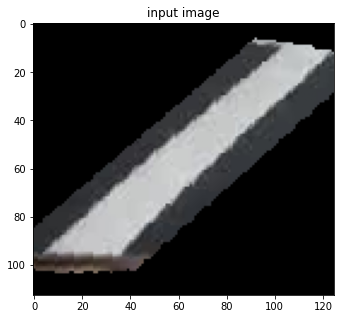

In [10]:
# Ensure that we are getting correct data from data loaders
batch_img, degradation_values = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
print("Degradation label shape:", degradation_values.shape) 

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

# sample_mask = batch_mask[0].numpy()   # (c, h, w)
# sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(sample_img)
ax.set_title("input image")

print("Degradation target:", degradation_values[0])

In [12]:
# Initializing the model, loss function, and the optimizer
model_name = "cnn_sppf"
model = get_model(model_name, in_channels=model_config['in_channels'], out_dim=model_config['out_dim'])
model = model.to(training.DEVICE)

# criterion = nn.MSELoss() # Loss for regression
# class_weights = torch.tensor([1.5, 1.2, 1]).to(training.DEVICE)  # Weights for class 0, 1, and 2
criterion = nn.CrossEntropyLoss() # Loss for classification multi-class classification

# from focal_loss import FocalLoss
# num_classes = 3
# alpha = [1.0, 1.0, 1.0]  # Example class weights
# criterion = FocalLoss(gamma=2, alpha=alpha, task_type='multi-class', num_classes=num_classes)

optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"], weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=train_config["learning_rate"])

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))

In [13]:
from torchinfo import summary
summary(model, input_size=(1, 3, 25, 25))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_SPPF                                 [1, 3]                    --
├─Conv2d: 1-1                            [1, 16, 25, 25]           448
├─Conv2d: 1-2                            [1, 32, 12, 12]           4,640
├─Conv2d: 1-3                            [1, 64, 6, 6]             18,496
├─SPPF: 1-4                              [1, 128, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 32, 6, 6]             2,080
│    └─MaxPool2d: 2-2                    [1, 32, 6, 6]             --
│    └─MaxPool2d: 2-3                    [1, 32, 6, 6]             --
│    └─MaxPool2d: 2-4                    [1, 32, 6, 6]             --
│    └─Conv2d: 2-5                       [1, 128, 6, 6]            16,512
├─AdaptiveAvgPool2d: 1-5                 [1, 128, 1, 1]            --
├─Linear: 1-6                            [1, 64]                   8,256
├─Linear: 1-7                            [1, 3]                    

In [14]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"])

Training Started...


epoch: 0:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 0:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 0.8176, Val Loss: 0.8906, Epoch execution time: 22.62 sec


epoch: 1:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 1:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.8195, Val Loss: 0.9039, Epoch execution time: 9.49 sec


epoch: 2:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 2:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.8157, Val Loss: 0.8866, Epoch execution time: 9.83 sec


epoch: 3:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 3:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.8198, Val Loss: 0.9194, Epoch execution time: 10.07 sec


epoch: 4:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 4:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.8140, Val Loss: 0.8958, Epoch execution time: 9.83 sec


epoch: 5:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 5:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.8166, Val Loss: 0.9284, Epoch execution time: 9.05 sec


epoch: 6:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 6:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.8145, Val Loss: 0.8966, Epoch execution time: 8.69 sec


epoch: 7:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 7:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.8180, Val Loss: 0.9131, Epoch execution time: 9.87 sec


epoch: 8:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 8:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.8097, Val Loss: 0.9205, Epoch execution time: 9.42 sec


epoch: 9:   0%|          | 0/1050 [00:00<?, ?it/s]

epoch: 9:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.8093, Val Loss: 0.9077, Epoch execution time: 9.67 sec
   Learning curve saved to experiment_results/train_log/learning_curve_2025-04-07_11-17-13.png
   Learning history saved to experiment_results/train_log/learning_history_2025-04-07_11-17-13.json
Model saved at: experiment_results/checkpoints/cnn_sppf_final_2025-04-07_11-17-13.pth
Training Completed! Total time: 1.8105 min


In [ ]:
# open saved learning curve
# plot_saved_path = "experiment_results/train_log/learning_curve_2025-04-07_02-16-57.png"
# plot_saved_path = "experiment_results/train_log/learning_curve_2025-04-07_05-27-50.png"
# plot_saved_path = "experiment_results/train_log/learning_curve_2025-04-07_05-33-02.png"
# plot_saved_path = "experiment_results/train_log/learning_curve_2025-04-07_05-23-15.png"
plot_saved_path = "experiment_results/train_log/learning_curve_2025-04-07_11-11-38.png"
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [15]:
# Evaluate model performance at end of training using different losses
train_metrics, train_cm = cal_classification_metrics(model, train_loader, num_classes=3)
val_metrics, val_cm = cal_classification_metrics(model, val_loader, num_classes=3)

  0%|          | 0/1050 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

,train,val
accuracy,0.6133,0.6126
precision,0.5682,0.5656
recall,0.6133,0.6126
f1,0.5589,0.5570


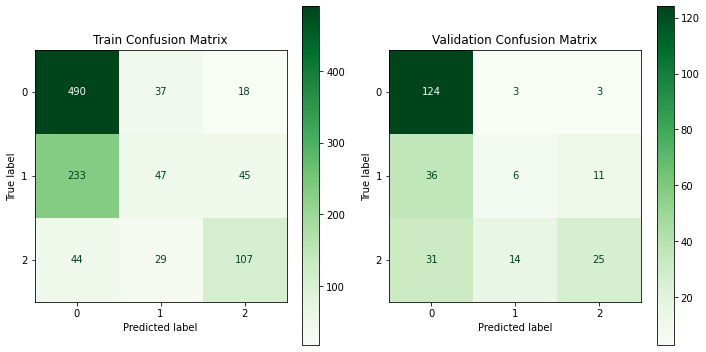

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

stats = pd.DataFrame([train_metrics, val_metrics], index=["train", "val"]).T
display(stats)

# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Plot the train confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp_train.plot(ax=ax[0], cmap='Greens')
ax[0].set_title("Train Confusion Matrix")

# Plot the validation confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp_val.plot(ax=ax[1], cmap='Greens')  # Plot on the second subplot
ax[1].set_title("Validation Confusion Matrix")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [17]:
def generate_saliency_map(model, image, target_class=None, device="cpu"):
    """
    Generate the saliency map for a given image using the model.

    Parameters:
        model (nn.Module): The model to compute the saliency map for.
        image (Tensor): The input image tensor with shape (C, H, W).
        target_class (int or None): The class index to compute the saliency map for. If None, uses the class with the highest score.

    Returns:
        saliency_map (Tensor): The saliency map highlighting the important regions.
    """

    # Define image transformation
    img_transform = transforms.Compose([ transforms.ToTensor() ])
    
    # Apply transformation and move to device
    input_tensor = img_transform(image).unsqueeze(0).to(device)  # Add batch dimension
    input_tensor.requires_grad_(True)  # Enable gradient computation for the input

    # Ensure the model is in evaluation mode
    model.eval()
    output = model(input_tensor)  # Forward pass

    # If no target class is specified, use the class with the highest output score
    if target_class is None:
        target_class = output.argmax(dim=1).item()
        print("predicted class", target_class)

    model.zero_grad()   # Zero all existing gradients

    # Compute the gradient of the output with respect to the input image for the target class
    output[0, target_class].backward()

    # Get the absolute value of the gradients
    saliency_map, _ = torch.max(input_tensor.grad.data.abs(), dim=1)

    # Normalize the saliency map to [0, 1]
    saliency_map = saliency_map.squeeze().cpu().detach().numpy()
    saliency_map = np.maximum(saliency_map, 0)
    saliency_map = saliency_map / (saliency_map.max() + 1e-6)

    return saliency_map

In [18]:
csv_path = dataset_config["val"]["degradation_values_csv"]
dir_path = dataset_config["val"]["img_dir"]
df = pd.read_csv(csv_path)
df.head(3)

,name,degradation_target
0,c9d61a6d-986df2e9_3.png,0
1,c9d61a6d-986df2e9_5.png,0
2,c9d61a6d-986df2e9_6.png,2


In [27]:
row = df.sample(1)
img_name, label = row["name"].values[0], row["degradation_target"].values[0]
p = os.path.join(dir_path, img_name)
img = load_image(p)

target class 0
predicted class 0


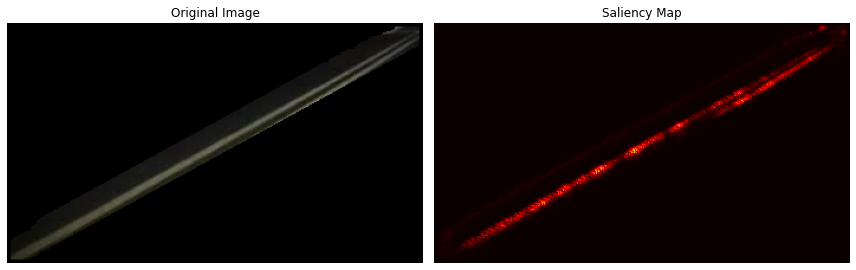

In [28]:
# Generate saliency map
print("target class", label)
saliency = generate_saliency_map(model, img, device=training.DEVICE)

# Plot the saliency map
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the saliency map
axes[1].imshow(saliency, cmap='hot')
axes[1].set_title('Saliency Map')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Inference

In [ ]:
saved_weight_path = "experiment_results/checkpoints/cnn_sppf_final_2025-03-13_18-02-43.pth"

model_name = "cnn_sppf"
model_config = {'in_channels': 3, 'out_dim': 1}

In [ ]:
# update preprocessing according to training
resize_height, resize_width = 720, 1280

# Define the image transformations
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((resize_height, resize_width)),   # ensure resize is same as used during training for loaded model 
    transforms.ToTensor()
])

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

In [ ]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

In [ ]:
test_img_path = "../damage_ratio_calc_data/segmented_objects/191_jpg.rf.e27c030e763e58ce48964e670158b6e7/191_jpg.rf.e27c030e763e58ce48964e670158b6e7_object_4.png"
test_img = load_image(test_img_path)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [ ]:
pred_val = pred_degradation_value(model=model, test_img=test_img, img_transform=None, add_batch_dim=True, device=DEVICE)
print("Predicticted degradation value:", pred_val)